# Toomre's stability criterion for a Kuzmin disc (2)

## Imports

In [3]:
import numpy as np
import scipy
import math
import random
import pandas as pd
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

rc_params = {'backend': 'ps',
            'font.family': 'Times New Roman',
            'font.sans-serif': ['Bitstream Vera Sans'],
            'axes.unicode_minus':False,
            'text.usetex':True,
            'axes.grid':True,
            'grid.linestyle':'-',
            'grid.linewidth':0.5,
            'hist.bins':50,
            'axes.labelsize':14,
            'axes.titlesize':14,
            'xtick.labelsize':10,
            'ytick.labelsize':10,
            'legend.fontsize':10,
            'savefig.bbox':'tight',
            'savefig.transparent':False,
            'figure.dpi':100}
plt.rcParams.update(rc_params)

In [4]:
def dati (data,N):

    step = N*3+3
    
    t = np.array([data.iloc[2::step,0].copy().dropna()]).flatten()
    m = np.array([data.iloc[i::step,0].copy().dropna() for i in range(3, N+3)])
    x = np.array([data.iloc[i::step,0].copy().dropna() for i in range(N+3, 2*N+3)])
    y = np.array([data.iloc[i::step,1].copy().dropna() for i in range(N+3, 2*N+3)])
    z = np.array([data.iloc[i::step,2].copy().dropna() for i in range(N+3, 2*N+3)])
    vx = np.array([data.iloc[i::step,0].copy().dropna() for i in range(2*N+3, 3*N+3)])
    vy = np.array([data.iloc[i::step,1].copy().dropna() for i in range(2*N+3, 3*N+3)])
    vz = np.array([data.iloc[i::step,2].copy().dropna() for i in range(2*N+3, 3*N+3)])
    M = m[::,0]
    
    r = np.array([(x[i]**2+y[i]**2+z[i]**2)**0.5 for i in range(N)])
    theta = np.array([np.arccos(x[i]/r[i]) for i in range(N)])
    
    for i in range(N):
        theta[i][y[i]<0] = -theta[i][y[i]<0]
    return x,y,z,vx,vy,vz,r,t,theta,M

def find_nearest(array, value):
    array = np.asarray(array)
    idx   = (np.abs(array-value)).argmin()
    return idx

## Parameters of the system

In [5]:
a = 10
G = 1
M_tot = 10
beta = 0.1
N = 133000

In [6]:
Sigma_R = lambda R : M_tot/(2*np.pi) * a /((R**2+a**2)**(3/2))
M_R = lambda R : M_tot*( 1 -(1 /( R**2/a**2 +1 )**(1/2)))
R_M = lambda M : ( ( 1 / (1-(M/M_tot))**2 ) - 1 )**(1/2) * a
theta_punto_R = lambda R : (G*M_tot/(R**2 + a**2)**(3/2))**(1/2)
k_R = lambda R : (G*M_tot*(-(3*R**2)/(R**2 + a**2)**(5/2) + 4/(R**2 + a**2)**(3/2)))**(1/2)
sigma_R = lambda R : beta*R*theta_punto_R(R)
Q_R = lambda R : sigma_R(R)*k_R(R)/(3.36*G*Sigma_R(R))
R_grid = np.geomspace(1e-3, 1e6, 10000)
R_Q = interpolate.interp1d(Q_R(R_grid),R_grid)


## Result of the simulation

In [7]:
n=3
data = pd.read_csv('output'+str(n)+'.txt', names = list(range(3)), sep = '\s+')

In [8]:
x,y,z,vx,vy,vz,r,time,theta,M = dati(data,N)

## Analysis : fragmentation

In [9]:
Q_val = [1e-1,1,2,3,5,10]
R_shell = np.array([R_Q(q) for q in Q_val])
R_shell = np.insert(R_shell,0,0)
R_shell = np.append(R_shell, 1e5)
idx_shell = np.arange(len(R_shell))

idx_t1 = [0,1,2,3,4,5,6,7,8,9,10]
idx_t2 = [0,5,10,15,20,25,30,35,40,45,50]
idx_t3 = [0,50,100,150,200,250,300,350,450,500]
idx_t_tot = np.append(idx_t1,idx_t2)
idx_t_tot = np.append(idx_t_tot,idx_t3)
Sigma_mean = {}
Sigma_dev = {}
for j in idx_shell[1:-1]:
    Sigma_mean[j] =[]
    Sigma_dev[j] = []
    
    for k in idx_t_tot:
        
        R_tot = r[::,k]
        theta_tot = theta[::,k]
        R = R_tot [np.logical_and(R_tot>R_shell[j],R_tot<R_shell[j+1])]
        sort = np.argsort(R)
        R = R[sort]
        shell_theta  = np.linspace(-np.pi,np.pi,100)
        shell_theta_med = (shell_theta[:-1]+shell_theta[1:]) / 2
        
        shell_A = np.array([(R_shell[j+1]**2 - R_shell[j]**2)*np.pi/50 for i in range(len(shell_theta)-1)])
        shell_M = np.array([np.sum(M[np.logical_and(np.logical_and(R_tot>R_shell[j],R_tot<R_shell[j+1]),np.logical_and(theta_tot>shell_theta[i],theta_tot<shell_theta[i+1]))]) for i in range(len(shell_theta)-1)])
        shell_Sigma = shell_M/shell_A
        Sigma_mean[j] = np.append(Sigma_mean[j],np.mean(shell_Sigma))
        Sigma_dev[j] = np.append(Sigma_dev[j], np.std(shell_Sigma))

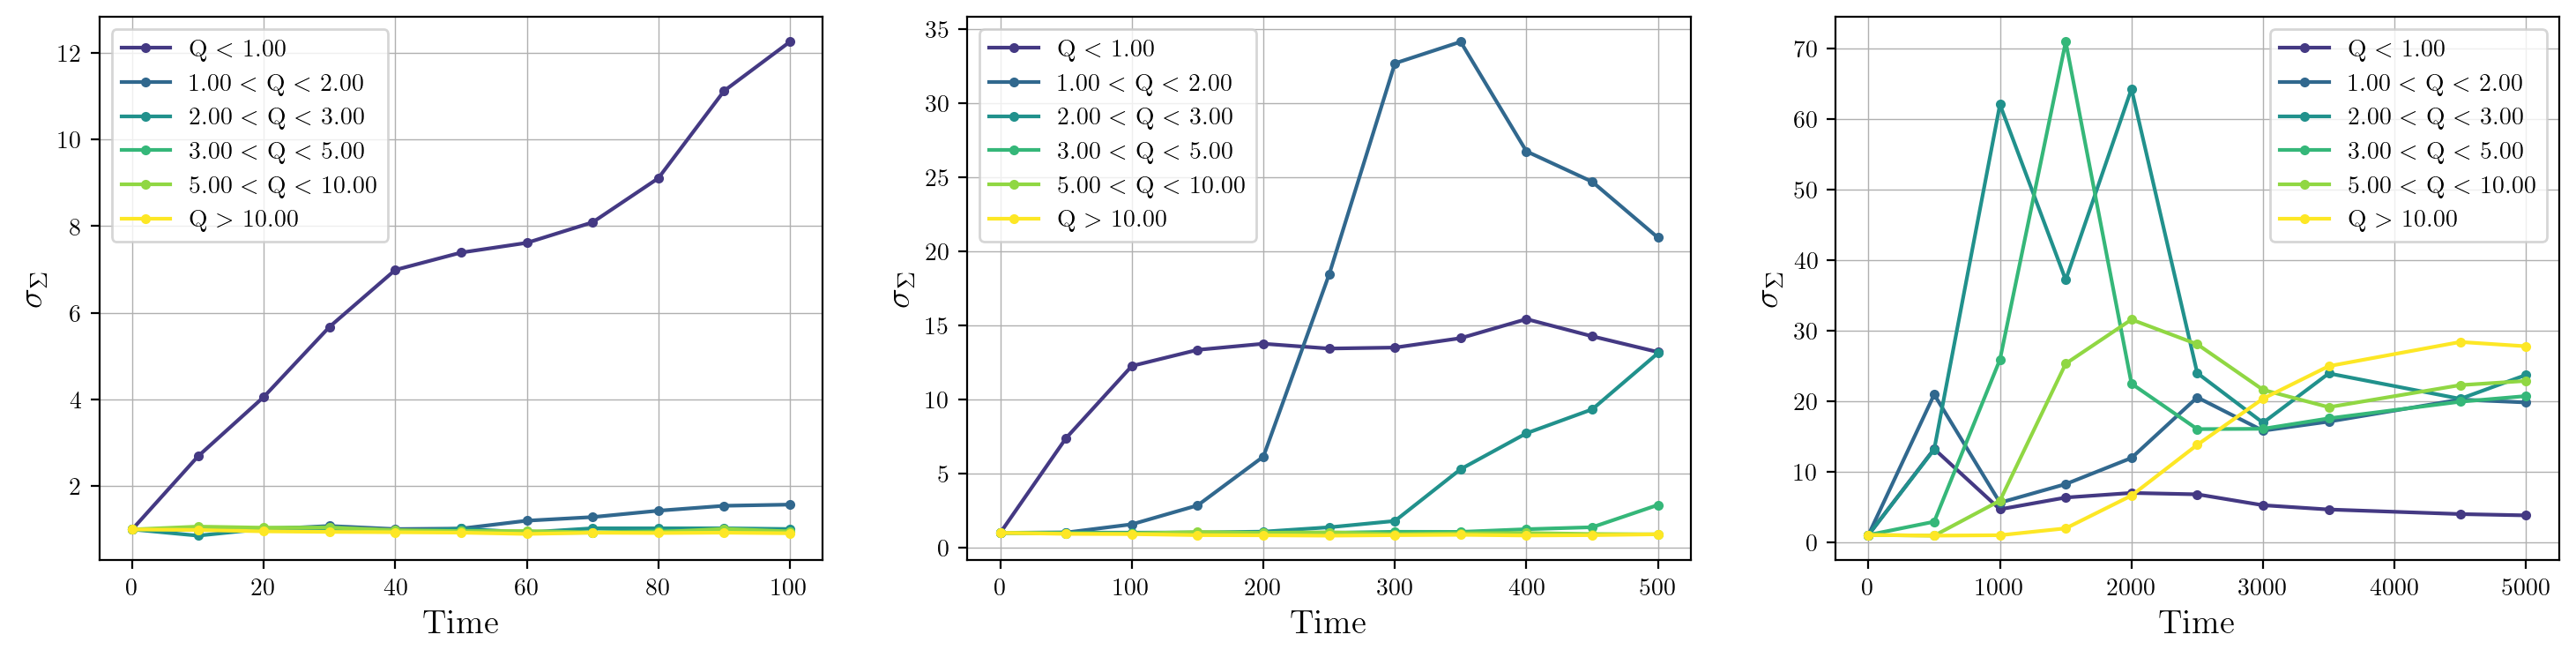

In [10]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))

col=plt.colormaps['viridis'](np.linspace(0,1,7))

for j in idx_shell[1:-1]:        
 
    if (j==idx_shell[1]):
        ax1.plot(time[idx_t1],Sigma_dev[j][:len(idx_t1)]/Sigma_dev[j][0],'-o', markersize=3, c=col[j], label='Q $<$ %.2f'%Q_val[j])
        ax2.plot(time[idx_t2],Sigma_dev[j][len(idx_t1):len(idx_t1)+len(idx_t2)]/Sigma_dev[j][0],'-o', markersize=3, c=col[j], label='Q $<$ %.2f'%Q_val[j])
        ax3.plot(time[idx_t3],Sigma_dev[j][len(idx_t1)+len(idx_t2):]/Sigma_dev[j][0],'-o', markersize=3, c=col[j], label='Q $<$ %.2f'%Q_val[j])

    elif (j==idx_shell[-2]):
        ax1.plot(time[idx_t1],Sigma_dev[j][:len(idx_t1)]/Sigma_dev[j][0],'-o', markersize=3, c=col[j], label='Q $>$ %.2f'%Q_val[j-1])
        ax2.plot(time[idx_t2],Sigma_dev[j][len(idx_t1):len(idx_t1)+len(idx_t2)]/Sigma_dev[j][0],'-o', markersize=3, c=col[j], label='Q $>$ %.2f'%Q_val[j-1])
        ax3.plot(time[idx_t3],Sigma_dev[j][len(idx_t1)+len(idx_t2):]/Sigma_dev[j][0],'-o', markersize=3, c=col[j], label='Q $>$ %.2f'%Q_val[j-1])
    else:
        ax1.plot(time[idx_t1],Sigma_dev[j][:len(idx_t1)]/Sigma_dev[j][0],'-o', markersize=3, c=col[j], label='%.2f $<$ Q $<$ %.2f'%(Q_val[j-1],Q_val[j]))
        ax2.plot(time[idx_t2],Sigma_dev[j][len(idx_t1):len(idx_t1)+len(idx_t2)]/Sigma_dev[j][0],'-o', markersize=3, c=col[j], label='%.2f $<$ Q $<$ %.2f'%(Q_val[j-1],Q_val[j]))
        ax3.plot(time[idx_t3],Sigma_dev[j][len(idx_t1)+len(idx_t2):]/Sigma_dev[j][0],'-o', markersize=3, c=col[j], label='%.2f $<$ Q $<$ %.2f'%(Q_val[j-1],Q_val[j]))

for ax in (ax1,ax2,ax3):
    
    ax.set_xlabel('Time')
    ax.set_ylabel(r'$\sigma_{\Sigma}$')
    ax.legend()
#plt.savefig('sigma_density.png',dpi=300)
plt.show()

In [11]:
idx_t1 = [0,1,2,3,4,5,6,7,8,9,10]
idx_t2 = [0,5,10,15,20,25,30,35,40,45,50]
idx_t3 = [0,50,100,150,200,250,300,350,450,500]
idx_t_tot = np.append(idx_t1,idx_t2)
idx_t_tot = np.append(idx_t_tot,idx_t3)
Sigma_mean = {}
Sigma_dev = {}
for j in idx_shell[1:-1]:
    Sigma_mean[j] =[]
    Sigma_dev[j] = []
    mask = np.logical_and(r[::,0]>R_shell[j],r[::,0]<R_shell[j+1])
    M_masked = M[mask]

    for k in idx_t_tot:
        
        R_tot = r[::,k][mask]
        theta_tot = theta[::,k][mask]
       
        shell_theta  = np.linspace(-np.pi,np.pi,100)
        shell_theta_med = (shell_theta[:-1]+shell_theta[1:]) / 2
        
        shell_A = np.array([(R_shell[j+1]**2 - R_shell[j]**2)*np.pi/50 for i in range(len(shell_theta)-1)])
        shell_M = np.array([np.sum(M_masked[np.logical_and(np.logical_and(R_tot>R_shell[j],R_tot<R_shell[j+1]),np.logical_and(theta_tot>shell_theta[i],theta_tot<shell_theta[i+1]))]) for i in range(len(shell_theta)-1)])
        shell_Sigma = shell_M/shell_A
        Sigma_mean[j] = np.append(Sigma_mean[j],np.mean(shell_Sigma))
        Sigma_dev[j] = np.append(Sigma_dev[j], np.std(shell_Sigma))

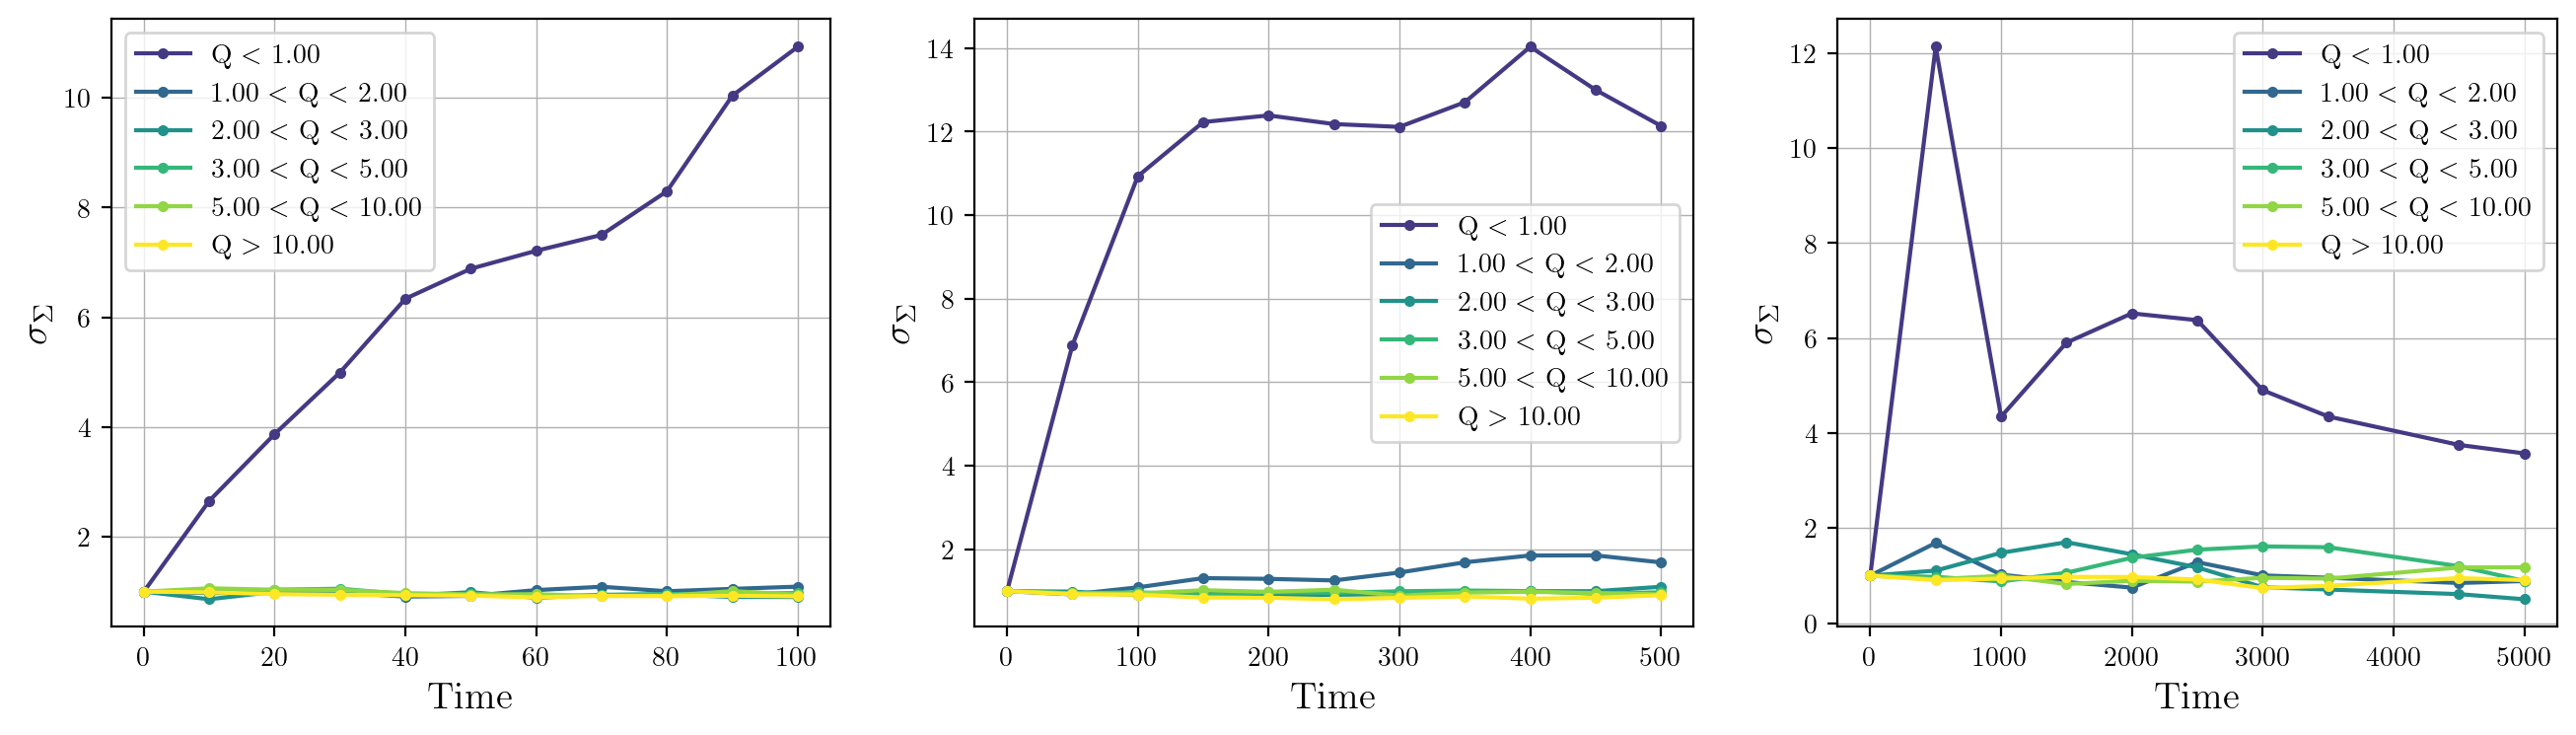

In [12]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,4))

col=plt.colormaps['viridis'](np.linspace(0,1,7))

for j in idx_shell[1:-1]:        
 
    if (j==idx_shell[1]):
        ax1.plot(time[idx_t1],Sigma_dev[j][:len(idx_t1)]/Sigma_dev[j][0],'-o', markersize=3, c=col[j], label='Q $<$ %.2f'%Q_val[j])
        ax2.plot(time[idx_t2],Sigma_dev[j][len(idx_t1):len(idx_t1)+len(idx_t2)]/Sigma_dev[j][0],'-o', markersize=3, c=col[j], label='Q $<$ %.2f'%Q_val[j])
        ax3.plot(time[idx_t3],Sigma_dev[j][len(idx_t1)+len(idx_t2):]/Sigma_dev[j][0],'-o', markersize=3, c=col[j], label='Q $<$ %.2f'%Q_val[j])

    elif (j==idx_shell[-2]):
        ax1.plot(time[idx_t1],Sigma_dev[j][:len(idx_t1)]/Sigma_dev[j][0],'-o', markersize=3, c=col[j], label='Q $>$ %.2f'%Q_val[j-1])
        ax2.plot(time[idx_t2],Sigma_dev[j][len(idx_t1):len(idx_t1)+len(idx_t2)]/Sigma_dev[j][0],'-o', markersize=3, c=col[j], label='Q $>$ %.2f'%Q_val[j-1])
        ax3.plot(time[idx_t3],Sigma_dev[j][len(idx_t1)+len(idx_t2):]/Sigma_dev[j][0],'-o', markersize=3, c=col[j], label='Q $>$ %.2f'%Q_val[j-1])
    else:
        ax1.plot(time[idx_t1],Sigma_dev[j][:len(idx_t1)]/Sigma_dev[j][0],'-o', markersize=3, c=col[j], label='%.2f $<$ Q $<$ %.2f'%(Q_val[j-1],Q_val[j]))
        ax2.plot(time[idx_t2],Sigma_dev[j][len(idx_t1):len(idx_t1)+len(idx_t2)]/Sigma_dev[j][0],'-o', markersize=3, c=col[j], label='%.2f $<$ Q $<$ %.2f'%(Q_val[j-1],Q_val[j]))
        ax3.plot(time[idx_t3],Sigma_dev[j][len(idx_t1)+len(idx_t2):]/Sigma_dev[j][0],'-o', markersize=3, c=col[j], label='%.2f $<$ Q $<$ %.2f'%(Q_val[j-1],Q_val[j]))

for ax in (ax1,ax2,ax3):
    
    ax.set_xlabel('Time')
    ax.set_ylabel(r'$\sigma_{\Sigma}$')
    ax.legend()
#plt.savefig('sigma_density2.png',dpi=300)
plt.show()

## Analysis : evolution of the parameters

In [13]:
theta_punto = np.array([(vy[i]*x[i] - vx[i]*y[i])/r[i]**2 for i in range(N)])
v = np.array([(vx[i]**2+vy[i]**2)**(1/2) for i in range(N)])

In [14]:
idx_t = [0,1,10,100,500]
snaps=len(idx_t)

shell_Sigma={}
shell_k={}
shell_sigma={}
shell_Q={}

for j in range(snaps):
    R = r[::,j]
    V = v[::,j]
    Theta_punto = theta_punto[::,j]
    Theta_punto_sort = Theta_punto[np.argsort(R)]
    R_sorted = R[np.argsort(R)]
    shell_r  = np.geomspace(R_sorted[2],a,50)[1::3]
    shell_r = np.append(shell_r, np.geomspace(a+1,max(R),151))
    shell_r_med = (shell_r[:-1] + shell_r[1:]) / 2

    shell_A = np.array([np.pi*shell_r[i+1]**2 - np.pi*shell_r[i]**2 for i in range(len(shell_r)-1)])
    shell_M = np.array([np.sum(M[np.logical_and(R>shell_r[i],R<shell_r[i+1])]) for i in range(len(shell_r)-1)])
    shell_Sigma[j] = shell_M/shell_A
    
    Theta_punto_ext = np.array([np.mean(Theta_punto_sort[find_nearest(R_sorted,shell_r[i+1])-100:find_nearest(R_sorted,shell_r[i+1])+100]**2) for i in range(len(shell_r)-1)])
    Theta_punto_int = np.array([np.mean(Theta_punto_sort[find_nearest(R_sorted,shell_r[i])-100:find_nearest(R_sorted,shell_r[i])+100]**2) for i in range(len(shell_r)-1)])
    Theta_punto_ext[:10] = np.array([Theta_punto_sort[find_nearest(R_sorted,shell_r[i])] for i in range(10)])
    Theta_punto_int[:10] = np.array([Theta_punto_sort[find_nearest(R_sorted,shell_r[i])] for i in range(10)])
    shell_der = np.array([(Theta_punto_ext[i] - Theta_punto_int[i]) / (shell_r[i+1]-shell_r[i]) for i in range(len(shell_r)-1)])
    shell_k[j] = np.array([(np.mean(R[np.logical_and(R>shell_r[i],R<shell_r[i+1])]) * shell_der[i] + 4*np.mean(Theta_punto[np.logical_and(R>shell_r[i],R<shell_r[i+1])]**2))**(1/2)  for i in range(len(shell_r)-1)])

    shell_sigma[j] = np.array([np.std(V[np.logical_and(R>shell_r[i],R<shell_r[i+1])]) for i in range(len(shell_r)-1)])

    shell_Q[j] = shell_k[j]*shell_sigma[j] / (3.36*shell_Sigma[j])

/home/alice/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alice/.local/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_28445/3053486650.py:28: RuntimeWarning: invalid value encountered in double_scalars
  shell_k[j] = np.array([(np.mean(R[np.logical_and(R>shell_r[i],R<shell_r[i+1])]) * shell_der[i] + 4*np.mean(Theta_punto[np.logical_and(R>shell_r[i],R<shell_r[i+1])]**2))**(1/2)  for i in range(len(shell_r)-1)])


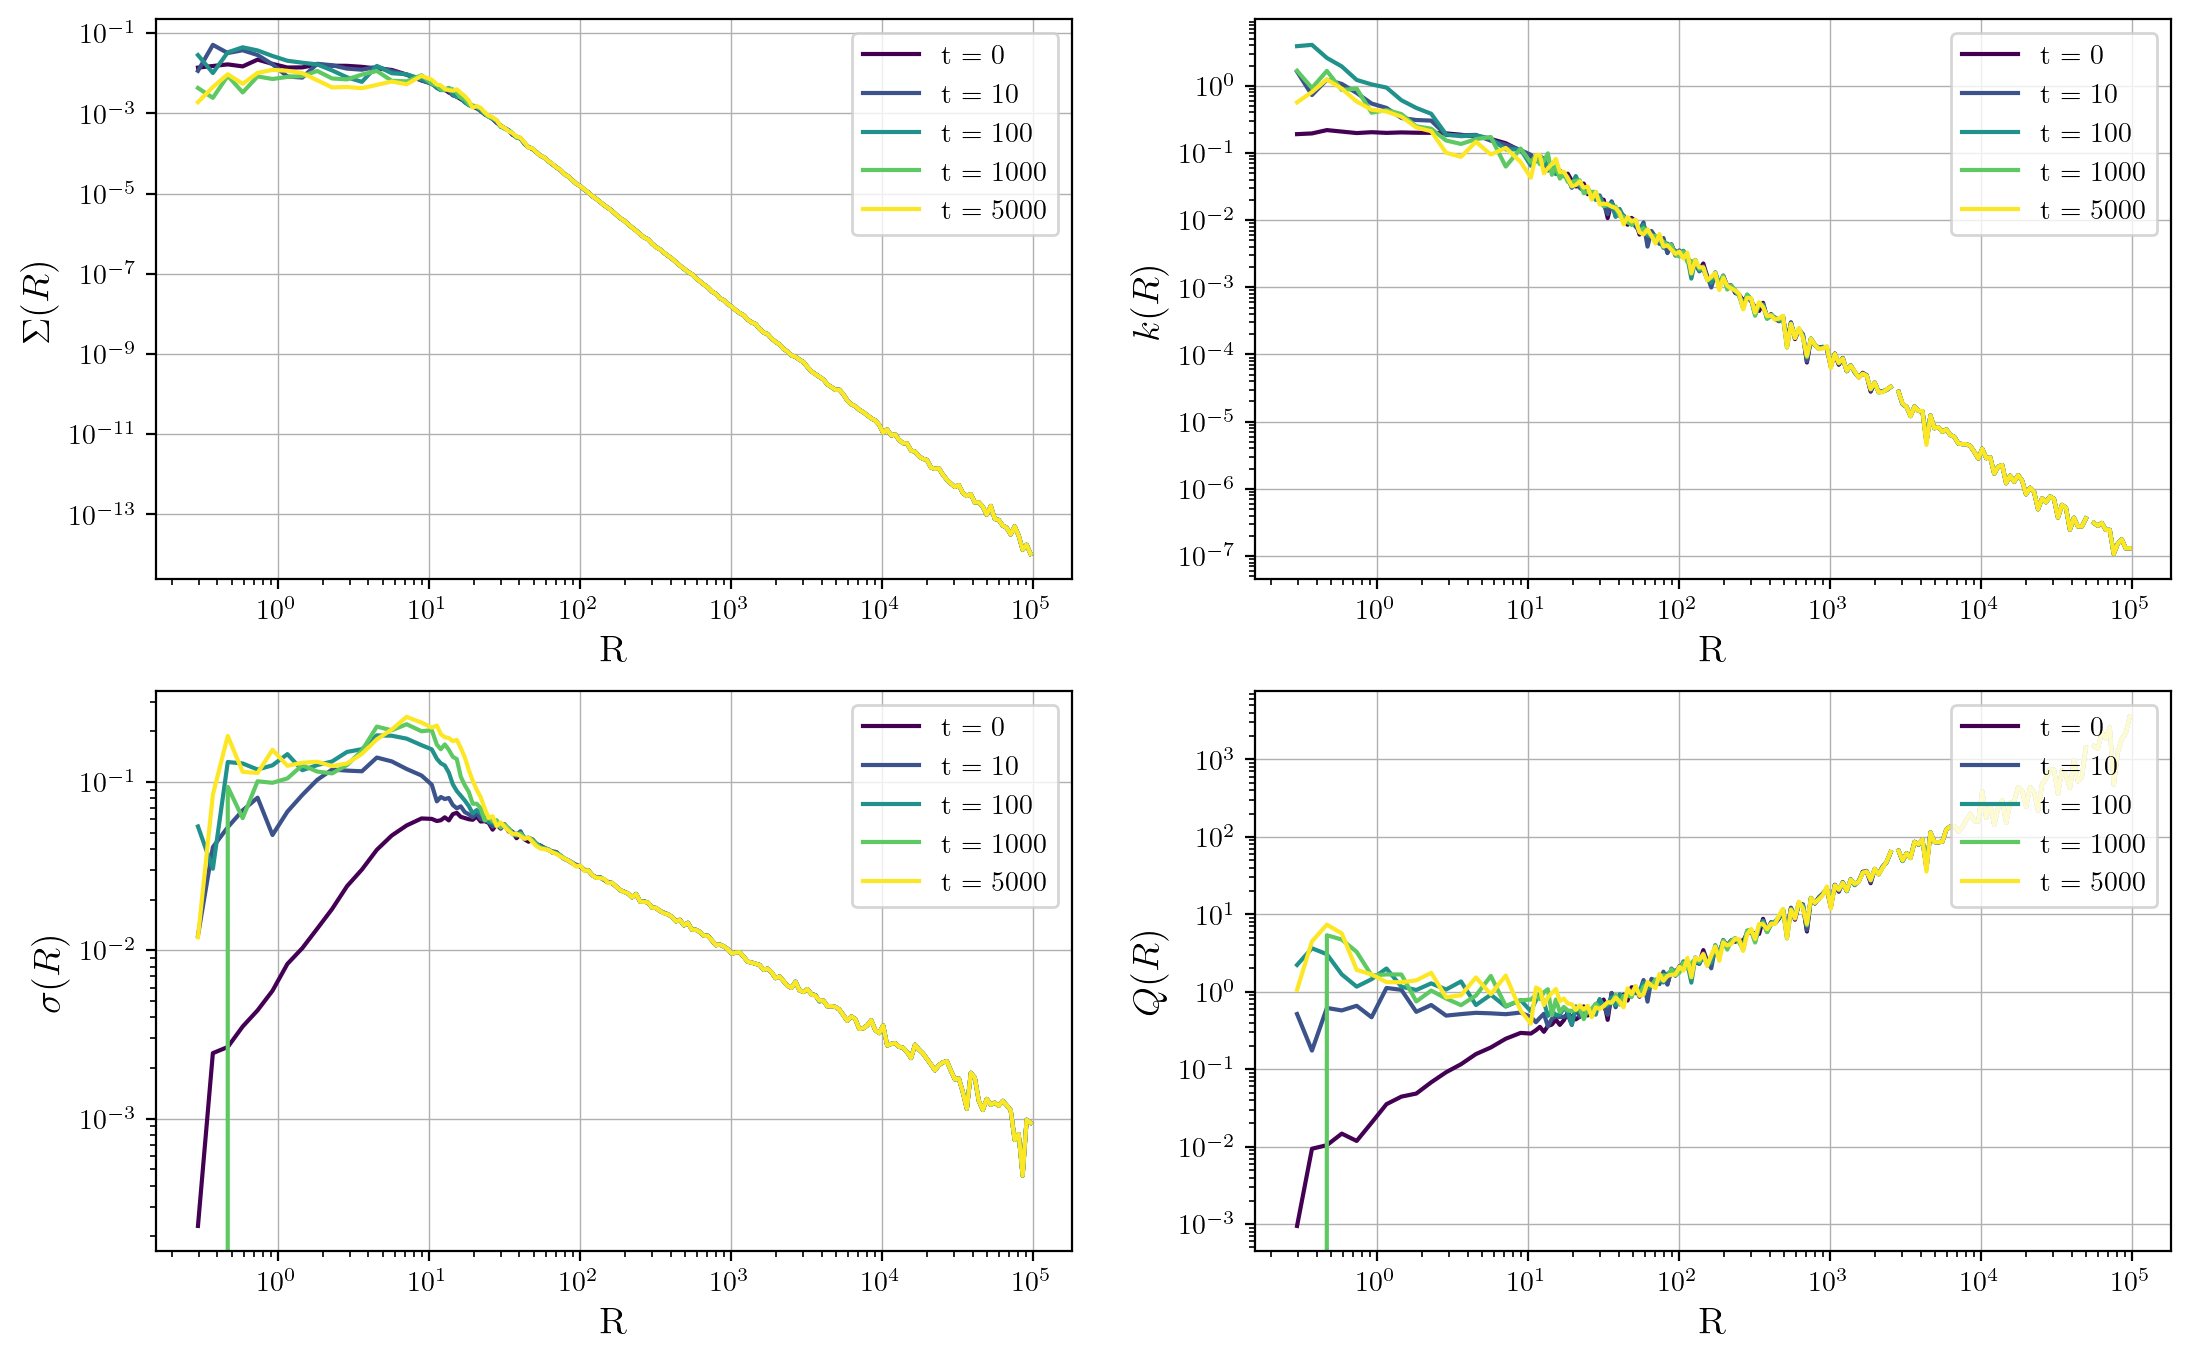

In [15]:
fig = plt.figure(figsize=(13,8))
col=plt.colormaps['viridis'](np.linspace(0,1,snaps))

ax = fig.add_subplot(221)
for j in range(snaps):
    ax.loglog(shell_r_med,shell_Sigma[j], c=col[j], label='t = %i'%time[idx_t[j]])
    ax.set_ylabel('$\Sigma(R)$')
    ax.set_xlabel('R')
    ax.legend(loc='upper right')

ax = fig.add_subplot(222)
for j in range(snaps):
    ax.loglog(shell_r_med,shell_k[j], c=col[j], label='t = %i'%time[idx_t[j]])
    ax.set_ylabel('$k(R)$')
    ax.set_xlabel('R')
    ax.legend(loc='upper right')

ax = fig.add_subplot(223)
for j in range(snaps):
    ax.loglog(shell_r_med,shell_sigma[j], c=col[j], label='t = %i'%time[idx_t[j]])
    ax.set_ylabel('$\sigma(R)$')
    ax.set_xlabel('R')
    ax.legend(loc='upper right')

ax = fig.add_subplot(224)
for j in range(snaps):
    ax.loglog(shell_r_med,shell_Q[j], c=col[j], label='t = %i'%time[idx_t[j]])
    ax.set_ylabel('$Q(R)$')
    ax.set_xlabel('R')
    ax.legend(loc='upper right')
#plt.savefig('profile_evolution.png',dpi=500)
plt.show()